<a href="https://colab.research.google.com/github/sudhir-voleti/Amazon-Shiny-Scraper/blob/main/Lec09_Colab_NLP_Word_vec_in_spaCy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Syntactic Dependency Parsing

Class,

We'll now surf the surface of syntactic dependency parsing from the Computational Linguistics (CL) area.

While NLP focuses on the tokens/tags as predictors in machine learning models, CL digs into the relationships and links among parts of speech.

Hence, CL looks into token organization and inter-related contexts within sentences using word-to-word grammar relationships which are also known as dependencies.

Without further ado, here we go:

In [ ]:
# setup chunk
!python -m spacy download en_core_web_md

import spacy
from spacy import displacy
import pandas as pd
import en_core_web_md
nlp = en_core_web_md.load()

import pandas as pd, time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Let's analyze one sentence using classical NLP approaches to better appreciate the stuff that a transformer unit in an LLM now does automatically.

Here's our sentence (say):

"Donald Trump was a controversial American President"

Next we 'parse' this sentence into it's primitive building blocks, detect 'parts of speech tags' or postags in the sentence, and tabulate the relations between those building blocks. Behold.

In [ ]:
# process a sentence using the model
sent = "Donald Trump was a controversial American President."

# routine to display sentence as DF postags
def token_attrib(sent0):
	doc = nlp(sent0)

	text=[]; lemma=[]; postag=[]; depcy=[]

	for token in doc:
		text.append(token.text)
		lemma.append(token.lemma_)
		postag.append(token.pos_)
		depcy.append(token.dep_)

	test_df = pd.DataFrame({'text':text, 'lemma':lemma, 'postag':postag, 'depcy':depcy})
	return(test_df)

# display the outp DF
token_attrib(sent)

,text,lemma,postag,depcy
0,Donald,Donald,PROPN,compound
1,Trump,Trump,PROPN,nsubj
2,was,be,AUX,ROOT
3,a,a,DET,det
4,controversial,controversial,ADJ,amod
5,American,american,ADJ,amod
6,President,President,PROPN,attr
7,.,.,PUNCT,punct


### Dependency parsing using parse-trees

Here's the first method below.

It will output a tree-structure of dependency relations, somewhat akin to the decision-trees of yore.

Further, within each branch,, we can expect to find meaningful text units (e.g., noun- and verb- phrases). Behold.

In [ ]:
# Repeating the tree parsing routine
from nltk import Tree
def to_nltk_tree(node):
	if node.n_lefts + node.n_rights > 0:
		return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
	else:
		return node.orth_

# print tree for seq of sents if needed
sent0 = "Donald Trump was a controversial American President."
sent = nlp(sent0)
[to_nltk_tree(sent.root).pretty_print() for sent in sent.sents]

           was                       
  __________|________                 
 |  Trump        President           
 |    |      ________|__________      
 .  Donald  a  controversial American



[None]

Note again the classic tree structure above with the root node being the ROOT verb.

#### Interpreting the Parse Tree

The ROOT node is the sentence's lynchpin. Without it, no grammatically correct sentence can form.

After the top (ROOT) node, the next level of nodes are the next most important in sentence formation. Then the next level and so on.

A token node above another in the parse tree is the ancestor node to the latter's descendent node.

So in the above sentence, going up the tree from the leaf nodes, 'Trump' and 'is' are ancestor nodes to 'Donald' whereas 'controversial' is a child node to 'president'.

#### Visualizing Syntactic Dependencies

Consider the following sentence and its syntactic dependencies.

In [ ]:
doc = nlp('Donald Trump was a controversial American President.'); doc

for token in doc:
    print(str(token.text),  str(token.lemma_),  str(token.pos_),  str(token.dep_))

from spacy import displacy
# type localhost:5000 (or whatever portnumber you get) in browser & refresh
displacy.render(doc, style = 'dep', jupyter = True)

Donald Donald PROPN compound
Trump Trump PROPN nsubj
was be AUX ROOT
a a DET det
controversial controversial ADJ amod
American american ADJ amod
President President PROPN attr
. . PUNCT punct


# Intro to Word Vector Models

Aim here is to demo the word vector representations capability in spaCy.

Stand-alone words (e.g., "bank") by themselves often can't convey much info because *context* is missing (e.g., "commercial bank" or "river bank").

For large numbers of common words, some idea about context (and relative probabilities of occurring in different contexts) can be had if models can be trained on large enough corpora (e.g., Wikipedia corpus, Goog News, Goog books etc.).

Imagine building a colossally high-D **vocabulary** space wherein words similar in meaning and context are closer together than to other words.

**Word embeddings** are real-number co-ordinate vectors representing a vocab's words in such a space (see example below).

To be useful, a set of word vectors for a vocabulary should capture

- (a) the meaning of words,
- (b) the relationship between words, and
- (c) the context of different words
- (d) as they are used naturally.

They allow us to implicitly include external information from the world into our language understanding models.

They thus have broad NLP applications in areas like sentiment-an, text classification etc.

### What are Word-vectors like?

In [ ]:
nlp = spacy.load('en_core_web_md')  # load medium-sized English model

# Here's a list of random tokens
tokens0 = "dog cat rose lily product brand"
#tokens0 = "astronomy humanities philosophy medicine engineering business law history theology"

# define func to execute wv conversion
def build_wv_df(tokens):
    tokens = nlp(tokens0)  # annotate doc
    data = {'token': [], 'wv_size':[], 'vector': []} # define empty dataframe 2 populate

    for token in tokens:
        data['token'].append(token.text)
        data['wv_size'].append(token.vector.shape)  # store size of the word-vec
        data['vector'].append(str(token.vector[:10]))  # Extract first 10 coords
    df = pd.DataFrame(data)
    return df

df = build_wv_df(tokens0)
print(df)

CPU times: user 9.17 ms, sys: 0 ns, total: 9.17 ms
Wall time: 9.24 ms
     token wv_size                                             vector
0      dog  (300,)  [  1.233     4.2963   -7.9738  -10.121     1.8...
1      cat  (300,)  [  3.7032     4.1982    -5.0002   -11.322     ...
2     rose  (300,)  [-0.94506 -6.8351  -2.4831   1.0674   1.6259  ...
3     lily  (300,)  [-3.9789   -3.6743   -3.6205    1.0236    2.55...
4  product  (300,)  [-2.2532  -1.3123  -1.0256   0.40066  5.215   ...
5    brand  (300,)  [-1.5951   2.3233  -0.71766 -0.17064  6.2635  ...


Although we humans can't tell that those numbers out there represent 'dogs' and 'cats' respectively, no such problem for machines.

Further, recognize what we have just achieved - reducing words to location co-ordinates in vocabulary space!

Analogous to how reducing text under bag-of-words (BOW) model to Document Token matrices (DTMs) enabled application of all variety of matrix ops to text collections.

IOW, with word-embeddings giving word locations in vocab space, the entire toolkit for spatial analytics can be brought to bear to analyze things like: <p>
- visualize word vector embeddings in 2- & 3-D spaces<p>
- similarities between words (how close are they in this space) <p>
- differences between words (how far apart) <p>
- context around words (which words occur most *around* focal words) <p>
- vector sums of word-aggregates (in a sentence, for example) <p>
- etc! <p>

### Visualizing Word-Vectors

Let's start with getting an intuitive feel for what words as vectors imply. Forward ahoy!

In [52]:
## --- Do PCA and project this 300-D object into 2-D or 3-D space, plot results

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def plot_wv(tokens0, k=2):  # only the vectors from df
    tokens = nlp(tokens0)
    vec_list = []
    for token in tokens:
        vec_list.append(token.vector)

    df_vec = pd.DataFrame(vec_list)
    df_vec.shape
    df = df_vec

    # Apply PCA to reduce dimensionality to 2 or 3 dimensions
    pca = PCA(n_components=k)
    principalComponents = pca.fit_transform(df)

    if (k == 2):
        # Plot vectors
        plt.figure()
        for i in range(len(principalComponents)):
            plt.arrow(0, 0, principalComponents[i][0], principalComponents[i][1])

            # Add simple arrow to show the end of vector
            plt.plot([principalComponents[i][0]], [principalComponents[i][1]], 'o')

            # Annotate the vector with its corresponding row number
            plt.annotate(tokens[i].text, (principalComponents[i][0]+0.5, principalComponents[i][1]))

        # Set plot limits to include all points by 50% on both sides
        plt.xlim((min(principalComponents[:,0])-0.5*(max(principalComponents[:,0]) - min(principalComponents[:,0])), max(principalComponents[:,0])+0.5*(max(principalComponents[:,0]) - min(principalComponents[:,0]))))
        plt.ylim((min(principalComponents[:,1])-0.5*(max(principalComponents[:,1]) - min(principalComponents[:,1])), max(principalComponents[:,1])+0.5*(max(principalComponents[:,1]) - min(principalComponents[:,1]))))
    elif (k==3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot vectors as arrows between origin and corresponding coordinates
        for i in range(len(principalComponents)):
            ax.quiver(0, 0, 0, principalComponents[i][0], principalComponents[i][1], principalComponents[i][2])

        # Annotate the vector with its corresponding row number
        for i in range(len(principalComponents)):
            ax.text(principalComponents[i][0], principalComponents[i][1], principalComponents[i][2], tokens[i].text, size=8, zorder=1, color='k')

        # Set plot limits
        ax.set_xlim([-np.max(principalComponents)*1.5, np.max(principalComponents)*1.5])
        ax.set_ylim([-np.max(principalComponents)*1.5, np.max(principalComponents)*1.5])
        ax.set_zlim([-np.max(principalComponents)*1.5, np.max(principalComponents)*1.5])

        # Add legend
        labels = ['PCA ' + str(i+1) for i in range(3)]

    plt.show()



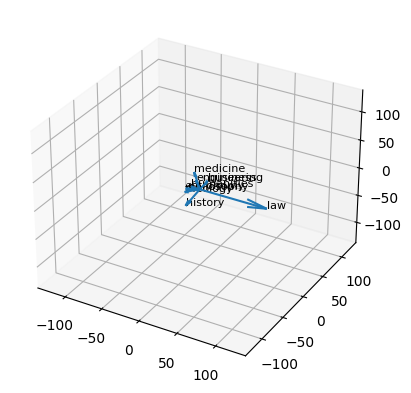

In [53]:
# invoke and test-drive the func
plot_wv(tokens0, 3)

Now that we have seen the visualization, let's quickly check off other items in the bulleted list we made above.

### Computing Word-Vec similarity

A quick dash to the slides for the concept of 'cosine similarity' and let's return once there.

Let's compute cosine similarity between words of interest viz. cats, dogs, daisies, lilies etc. Behold.    

In [ ]:
## --- input word tokens for word vector embedding based similarity calc
#tokens0 = "dog cat rose lily product brand"
tokens0 = "astronomy humanities philosophy medicine engineering business law history theology"
tokens = nlp(tokens0)  # annotate doc

# def func to build a cosine similarity table for any group of words
def build_cosine_simil_tbl(tokens0):
    # define tokens as words
    words = []
    for token in tokens:
      words.append(token.text)
    words

    # built empty dataframe to populate
    import numpy as np
    matrix0 = np.zeros((len(words),len(words)))
    simil_df = pd.DataFrame(matrix0, index=words, columns=words)

    # loop over, round-off similarity to 3 decimal places
    for i in range(len(tokens)):
      for j in range(len(tokens)):
        simil_df.iloc[i,j] = round(tokens[i].similarity(tokens[j]), 3)

    return(simil_df)

# test-drive the func
%time simil_df = build_cosine_simil_tbl(tokens0)
simil_df # view result


CPU times: user 23.8 ms, sys: 0 ns, total: 23.8 ms
Wall time: 23.9 ms


,astronomy,humanities,philosophy,medicine,engineering,business,law,history,theology
astronomy,1.000,0.462,0.593,0.396,0.507,0.290,0.206,0.571,0.578
humanities,0.462,1.000,0.481,0.382,0.543,0.436,0.250,0.494,0.544
philosophy,0.593,0.481,1.000,0.479,0.453,0.370,0.356,0.607,0.842
medicine,0.396,0.382,0.479,1.000,0.479,0.368,0.292,0.396,0.470
engineering,0.507,0.543,0.453,0.479,1.000,0.530,0.266,0.449,0.473
business,0.290,0.436,0.370,0.368,0.530,1.000,0.309,0.351,0.251
law,0.206,0.250,0.356,0.292,0.266,0.309,1.000,0.298,0.370
history,0.571,0.494,0.607,0.396,0.449,0.351,0.298,1.000,0.576
theology,0.578,0.544,0.842,0.470,0.473,0.251,0.370,0.576,1.000



### Vector Sums in Metric Vocab Spaces

Vectors can be added and subtracted in metric spaces (which vocab spaces are in 300+ dimns). They can also be multiplied and divided (dot- & cross- products and inverses, for example).

Below I demo what happens when we do Vector summation over natural word groupings (e.g., words in a sentence) to obtain a document level vocab space vector.

spaCy makes this incredibly convenient via the extension '.vector' to the annotated document. Result is the mean or average of the vector sum of all component tokens.

Behold.

In [ ]:
# simulate 3 sentences
sent1 = "Mozart's ninth symphony is considered his best."
sent2 = "The Unforgiven is a cult western."
sent3 = "Machine Learning basics for Managers."
sent4 = "Elon Musk wants to colonize Mars."

# use nlp() to annotate them into nlp objects
doc1 = nlp(sent1)
doc2 = nlp(sent2)
doc3 = nlp(sent3)
doc4 = nlp(sent4)

# view a few nums from the mean vector for the entire sentence
# (useful for sentence classification etc.)
print(doc1.vector[:8],"\n")
print(doc2.vector[:8],"\n")
print(doc3.vector[:8],"\n")

[-0.27679718  0.07001656 -0.02946705  0.2204387  -0.28788823  0.06652101
  0.2908046   0.21864551] 

[ 0.09406377 -0.34489995  0.1659308   0.33264995 -0.15493917  0.62710696
 -0.06976938 -0.05970565] 

[-0.9017957   0.34151062 -0.2076538  -0.04527247  0.21432579  0.26339224
  0.53493434  0.06920578] 



In [ ]:
# now examine which sents are closer to each other in context / meaning terms as per word-vec
sent_1=[]; sent_2=[]; simil_score=[]

for i in [1, 2, 3]:
    for j in [2, 3, 4]:
        sent_1.append(eval(str("sent" + str(i))))
        sent_2.append(eval(str("sent" + str(j))))
        simil_score.append(eval(str("doc" + str(i))).similarity(eval(str("doc" + str(j)))))

# store n display as DF
sent_simil_df = pd.DataFrame({'sent1':sent_1, 'sent2':sent_2, 'simil_score':simil_score})
sent_simil_df

<ipython-input-6-815fcabebc4f>:8: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  simil_score.append(eval(str("doc" + str(i))).similarity(eval(str("doc" + str(j)))))


,sent1,sent2,simil_score
0,Mozart's ninth symphony is considered his best.,The Unforgiven is a cult western.,0.598826
1,Mozart's ninth symphony is considered his best.,Machine Learning basics for Managers.,0.312249
2,Mozart's ninth symphony is considered his best.,Elon Musk wants to colonize Mars.,0.326421
3,The Unforgiven is a cult western.,The Unforgiven is a cult western.,1.000000
4,The Unforgiven is a cult western.,Machine Learning basics for Managers.,0.380788
5,The Unforgiven is a cult western.,Elon Musk wants to colonize Mars.,0.402980
6,Machine Learning basics for Managers.,The Unforgiven is a cult western.,0.380788
7,Machine Learning basics for Managers.,Machine Learning basics for Managers.,1.000000
8,Machine Learning basics for Managers.,Elon Musk wants to colonize Mars.,0.607204


Well, what do you think? Do the similarities make common sense?
We can compare similarity between text aggregates such as paragraphs and documents just as well.

Recall from MKTR we did cluster-an on the DTM to find docs that were 'similar' in their word features.

This is different in that we're using externally trained models to implicitly provide context during the similarity score computation.

BTW, why stop here. We march on to finding similarities within a corpus of random decent-sized documents.

Recall the Uber reviews dataset? Let's load it and compare individual reviews with one another. Behold.

In [34]:
## Loading uber reviews wala dataset
uber_df = pd.read_csv('https://raw.githubusercontent.com/sudhir-voleti/sample-data-sets/master/uber_reviews_itune.csv')
uber_df # view what dataset looks like

,Title,Author_URL,Author_Name,App_Version,Rating,Review,Date
0,Needs Fixed Interface,https://itunes.apple.com/us/reviews/id1191709596,bobums meatoe,3.440.10003,1,The interface for this app is miserable. I hav...,2021-01-21 02:14:12
1,Depletes battery too quickly on iPhone 12 Pro,https://itunes.apple.com/us/reviews/id305037564,Dalim93,3.440.10003,3,This app depletes my battery faster than my ph...,2021-01-21 01:51:52
2,Bad rating system.,https://itunes.apple.com/us/reviews/id899436747,Head5up,3.440.10003,2,I should not penalized for the length of wait ...,2021-01-21 00:44:33
3,Ok,https://itunes.apple.com/us/reviews/id354352937,Lena__xD,3.440.10003,4,El Nip que ingresamos al llegar con el comensa...,2021-01-20 21:34:47
4,Wheel chair vehicles not practical for some,https://itunes.apple.com/us/reviews/id412577199,kittenb21,3.440.10003,2,Your app doesn't have a place for me to send f...,2021-01-20 18:56:30
...,...,...,...,...,...,...,...
485,No Way.,https://itunes.apple.com/us/reviews/id912822185,NGxld,3.431.10001,2,Why Are Y’all Overpricing With These Rides It’...,2020-11-18 21:37:47
486,very poor customer service,https://itunes.apple.com/us/reviews/id211764770,delete uber forever,3.431.10001,1,Will give 0 star if possible,2020-11-18 21:23:35
487,Worse Customer Support Ever,https://itunes.apple.com/us/reviews/id352295754,awatterbottle,3.431.10001,1,These people are the worse. They make you wait...,2020-11-18 19:54:37
488,Worse Customer Support Ever,https://itunes.apple.com/us/reviews/id352295754,awatterbottle,3.431.10001,1,These people are the worse. They make you wait...,2020-11-18 19:54:37


#### Document Similarity computation

For any arbitrary set of documents, similarity in content slash meaning slash vocabulary spaces is what we are after, next.

Onward ho!

In [43]:
# select any random set of reviews
uber_subdf = uber_df.Review.iloc[[14,26,38,42]]; uber_subdf
text_series = uber_subdf

# def func to build a cosine similarity table for any group of words
def doc_cosine_simil_tbl(text_series):

    n1 = text_series.shape[0]
    list_vec = []; names = []
    for i in range(n1):
      doc = text_series.iloc[i]
      list_vec.append(nlp(doc))
      names.append("doc_" + str(i))

    # built empty dataframe to populate
    import numpy as np
    n1 = text_series.shape[0]
    matrix0 = np.zeros((n1, n1))
    simil_df = pd.DataFrame(matrix0, index=names, columns=names)

    # loop over, round-off similarity to 3 decimal places
    for i in range(n1):
      for j in range(n1):
        simil_df.iloc[i,j] = round(list_vec[i].similarity(list_vec[j]), 3)

    return(simil_df)

# test-drive the func
%time simil_df = doc_cosine_simil_tbl(uber_subdf)
simil_df # view result


CPU times: user 113 ms, sys: 0 ns, total: 113 ms
Wall time: 125 ms


,doc_0,doc_1,doc_2,doc_3
doc_0,1.000,0.612,0.552,0.115
doc_1,0.612,1.000,0.855,0.027
doc_2,0.552,0.855,1.000,0.031
doc_3,0.115,0.027,0.031,1.000


### Plotting Doc Embeddings in Latent Spaces

As before, we plot and see what the low dimensional projections of these reviews look like.

Since we can only plot in 2-D and 3-D, let's do so and see what and where these doc vectors reside and inter-relate. Behold.

In [54]:
##--- define func to build low-D plots ----
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def plot_doc_wv(text_series, k=2):  # only the vectors from df

    n1 = text_series.shape[0]
    list_vec = []; names = []
    for i in range(n1):
      doc = text_series.iloc[i]
      list_vec.append(nlp(doc).vector)
      names.append("doc_" + str(i))

    df_vec = pd.DataFrame(list_vec)
    df_vec.shape
    df = df_vec

    # Apply PCA to reduce dimensionality to 2 or 3 dimensions
    pca = PCA(n_components=k)
    principalComponents = pca.fit_transform(df)

    if (k == 2):
        # Plot vectors
        plt.figure()
        for i in range(len(principalComponents)):
            plt.arrow(0, 0, principalComponents[i][0], principalComponents[i][1])

            # Add simple arrow to show the end of vector
            plt.plot([principalComponents[i][0]], [principalComponents[i][1]], 'o')

            # Annotate the vector with its corresponding row number
            plt.annotate(names[i], (principalComponents[i][0]+0.5, principalComponents[i][1]))

        # Set plot limits to include all points by 50% on both sides
        plt.xlim((min(principalComponents[:,0])-0.5*(max(principalComponents[:,0]) - min(principalComponents[:,0])), max(principalComponents[:,0])+0.5*(max(principalComponents[:,0]) - min(principalComponents[:,0]))))
        plt.ylim((min(principalComponents[:,1])-0.5*(max(principalComponents[:,1]) - min(principalComponents[:,1])), max(principalComponents[:,1])+0.5*(max(principalComponents[:,1]) - min(principalComponents[:,1]))))
    elif (k==3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot vectors as arrows between origin and corresponding coordinates
        for i in range(len(principalComponents)):
            ax.quiver(0, 0, 0, principalComponents[i][0], principalComponents[i][1], principalComponents[i][2])

        # Annotate the vector with its corresponding row number
        for i in range(len(principalComponents)):
            ax.text(principalComponents[i][0], principalComponents[i][1], principalComponents[i][2], names[i], size=8, zorder=1, color='k')

        # Set plot limits
        ax.set_xlim([-np.max(principalComponents)*1.5, np.max(principalComponents)*1.5])
        ax.set_ylim([-np.max(principalComponents)*1.5, np.max(principalComponents)*1.5])
        ax.set_zlim([-np.max(principalComponents)*1.5, np.max(principalComponents)*1.5])

        # Add legend
        labels = ['PCA ' + str(i+1) for i in range(3)]

    plt.show()



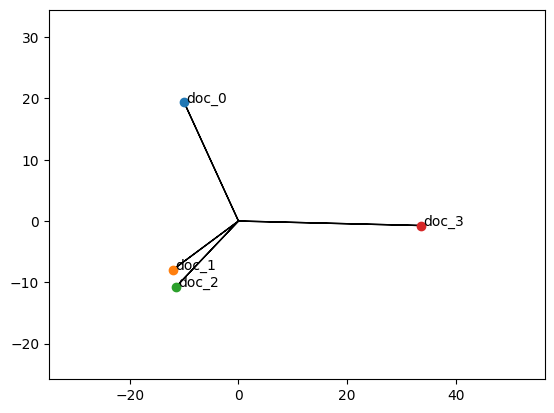

In [56]:
# invoke and test-drive the func
plot_doc_wv(uber_subdf, 2)

Will close with this. Back to the slides.

Sudhir Voleti